# Deep Learning
### 視程カテゴリーを予測する

#### データの前処理

In [1]:
import numpy as np
import pandas as pd
np.random.seed(443)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## 学習用データ
DATA = pd.read_csv("train_data.csv")

# 使うデータを限定
use_valiable = ["DateTime","VIS","VIS_CAT","FG","PRCP_P24HR",\
                "RH_SFC","TMP_SFC","TD_SFC","PRES_SFC","LCDC_SFC","MCDC_SFC","HCDC_SFC",\
                "WSPD_SFC","WDIR_SFC","APCP_SFC","TimeRange","MONTH","D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
                "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA",\
                "RH_1000","VVEL_1000","WSPD_1000","RH_975","VVEL_975","WSPD_975",\
                "RH_950","VVEL_950","WSPD_950","RH_850","RH_700","RH_500","RH_300"]
DATA = DATA[use_valiable]

# カテゴリー変数はダミー化
cat_val = ['WDIR_SFC', 'TimeRange', 'MONTH']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

# 雨が降った後の夜間に霧が出やすいことを表現できるかもしれない
DATA["Time_12-14_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_12-14"]
DATA["Time_15-17_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_15-17"]
DATA["Time_18-20_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_18-20"]
DATA["Time_21-23_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_21-23"]

# 不均衡データ対応
# VIS 5000m以上を減らし、VIS 5000m未満を増やす
def Sampling_Flag(data):
    flag = np.full( data.shape[0], 0 )
    flag[ data > 0 ] = 1
    return flag

DATA["FLAG"] = Sampling_Flag( DATA.VIS_CAT )

target = 'FLAG'
exclude = ['FLAG','DateTime']
features = [val for val in DATA.columns if val not in exclude]

y = np.array( DATA[target] )
X = np.array( DATA[features] )

# count = int( y[y==0].shape[0]/2 )
# rus = RandomUnderSampler(ratio={0:count}, random_state=443)
# X_rus, y_rus = rus.fit_sample(X,y)

# count = y_rus[y_rus==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X_rus,y_rus)

# count = y[y==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X,y)

# DATA = pd.DataFrame( X_sm, columns=features )
DATA = pd.DataFrame( X, columns=features )
DATA.FG = DATA.FG.astype(np.int64)
DATA.VIS_CAT = DATA.VIS_CAT.astype(np.int64)

In [3]:
## 予測テスト用データ
TEST = pd.read_csv("test_data.csv")
TEST = TEST[use_valiable].drop("DateTime", axis=1)
TEST = pd.get_dummies(data=TEST, columns=cat_val)

TEST["Time_12-14_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_12-14"]
TEST["Time_15-17_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_15-17"]
TEST["Time_18-20_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_18-20"]
TEST["Time_21-23_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_21-23"]

### Chainerで学習

In [4]:
from chainer import Chain, Variable, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam, MomentumSGD, RMSprop
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater
from chainer.training import Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import spearmanr
from pylab import rcParams
import re

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
target = 'VIS_CAT'
exclude = ['VIS','VIS_CAT','FG','PRCP_P24HR']
features = [val for val in DATA.columns if val not in exclude]

# 特徴量を割り算で作成
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(features)-1):
    for j in range(i+1, len(features)):
        first_col_name = features[i]
        second_col_name = features[j]
        r = spearmanr(DATA[first_col_name], DATA[second_col_name]).correlation        
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            DATA[new_colname] = DATA[first_col_name] / (DATA[second_col_name] + 0.001)
            new_added_col.append(new_colname)
features = features + new_added_col

# 増えた特徴量をテストデータでも作成
for feature in features:
    if re.search('_div_', feature):
        feature1, feature2 = feature.split("_div_")
        TEST[feature] = TEST[feature1] / (TEST[feature2] + 0.001)

X = DATA[features]
Y = DATA[target]
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

X_test = TEST[features]
Y_test = TEST[target]

In [6]:
## Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_dev = scaler.transform( X_dev )
X_test = scaler.transform( X_test )

## Chainer用の変換
Y_train = Y_train.values
Y_dev = Y_dev.values
Y_test = Y_test.values

X_train = X_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)
X_test = X_test.astype(np.float32)

Y_train = Y_train.astype(np.int32)
Y_dev = Y_dev.astype(np.int32)
Y_test = Y_test.astype(np.int32)

In [7]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(500)
            self.l2 = L.Linear(1000)
            self.l3 = L.Linear(500)
            self.l4 = L.Linear(5)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l3(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l4(h)
        return h

#### LOSSの重みを [1,1,1,2,2] にする
#### Adamの Learning Rate=0.0001 にする

In [15]:
## LOSS計算時に重み付けをする
def Loss_Func(x, t):
    cw = np.array([1, 1, 1, 2, 2]).astype(np.float32)
    return F.softmax_cross_entropy(x, t, class_weight=cw)

In [16]:
model = Model()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam(alpha=0.0001)
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=128, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=128, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=128, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(100, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   dev/main/loss  test/main/loss
100         0.633558    0.476638       0.439065        
200         0.50924     0.429764       0.404796        
300         0.463737    0.427337       0.409008        
400         0.436355    0.420194       0.402905        
500         0.420271    0.413486       0.396544        
600         0.413142    0.416396       0.4003          
700         0.407601    0.406375       0.390423        
800         0.407345    0.405795       0.39069         
900         0.391766    0.400443       0.38563         
1000        0.389692    0.405266       0.390541        
1100        0.391835    0.397023       0.382289        
1200        0.375837    0.398717       0.383087        
1300        0.38226     0.402757       0.390731        
1400        0.383268    0.395997       0.38426         
1500        0.3741      0.393339       0.379806        
1600        0.368119    0.389478       0.376653        
1700        0.365073    0.391369       0.380039   

,dev/main/accuracy,dev/main/loss,elapsed_time,epoch,iteration,main/accuracy,main/loss,test/main/accuracy,test/main/loss
95,0.891325,0.330955,212.321076,67,9600,0.905234,0.263491,0.890224,0.377246
96,0.892837,0.329910,214.551133,67,9700,0.905625,0.259533,0.888026,0.377384
97,0.893971,0.328028,216.782532,68,9800,0.905469,0.266413,0.890956,0.377157
98,0.893215,0.326888,219.032745,69,9900,0.904531,0.258285,0.891170,0.374676
99,0.893845,0.327134,221.309801,69,10000,0.907266,0.256311,0.891506,0.374074


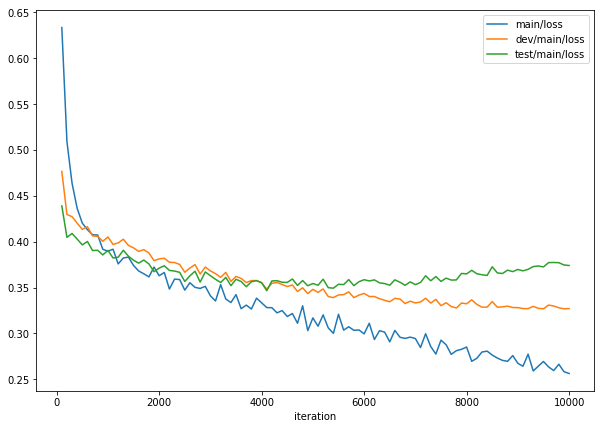

In [17]:
rcParams['figure.figsize'] = 10,7
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss", "test/main/loss"]].values, columns=["main/loss", "dev/main/loss", "test/main/loss"], index=log_df["iteration"]).plot()
log_df.tail()

In [18]:
## カテゴリー評価
def Category_Evaluation(obs_cat, fcst_cat):
    matrix = confusion_matrix(y_true=obs_cat, y_pred=fcst_cat)
    print( matrix )
    print( "Accuracy : ", accuracy_score( obs_cat, fcst_cat ) )
    print( "F1 average : ", f1_score( obs_cat, fcst_cat, average='macro' ) )
    print( "Weighted F1 : ", Weighted_F1(matrix) )
    print( "ETS 800m : ", ETS(obs_cat, fcst_cat, 4) )
    print( "BI 800m : ", BI(obs_cat, fcst_cat, 4) )
    print( "ETS 1600m : ", ETS(obs_cat, fcst_cat, 3) )
    print( "BI 1600m : ", BI(obs_cat, fcst_cat, 3) )

## Equitable Threat Score
def ETS(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    Pc = len(obs_onoff[ obs_onoff == 1 ]) / len(obs_onoff)
    Sf = Pc * ( m[1,1] + m[0,1] ) # ランダム的中率
    ets = ( m[1,1] - Sf ) / ( m[0,1] + m[1,0] + m[1,1] - Sf )
    return ets

## バイアススコア
def BI(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    bi = m[:,1].sum() / m[1,:].sum()
    return bi

## 各カテゴリーの総数の逆数で重み付け
# 低い視程カテゴリーの正解に重みをつけたい
def Weighted_F1(m):
    F1_score = []
    total = 0
    for i in range( len(m) ):
        if m[:,i].sum() == 0:
            precision = 0
        else:
            precision = m[i,i] / m[:,i].sum()

        if m[i,:].sum() == 0:
            recall = 0
        else:
            recall = m[i,i] / m[i,:].sum()

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        if m[i,:].sum() == 0:
            F1_score.append( 0 )
        else:
            F1_score.append( f1 / m[i,:].sum() )
            total += 1 / m[i,:].sum()

    fin_score = sum( F1_score ) / total
    return fin_score

In [19]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
# pd.crosstab(Y_dev, y_pred)
Category_Evaluation(Y_dev, y_pred)

             precision    recall  f1-score   support

          0       0.94      0.98      0.96      6956
          1       0.36      0.17      0.23       456
          2       0.46      0.32      0.38       327
          3       0.19      0.32      0.24        60
          4       0.36      0.50      0.42        56

avg / total       0.87      0.89      0.88      7855

[[6787   72   50   28   19]
 [ 286   76   62   19   13]
 [ 132   56  106   25    8]
 [  21    4    7   19    9]
 [  10    5    4    9   28]]
Accuracy :  0.8931890515595162
F1 average :  0.4447013438679651
Weighted F1 :  0.3326496376392525
ETS 800m :  0.26281258265150287
BI 800m :  1.375
ETS 1600m :  0.2767966480043018
BI 1600m :  1.5258620689655173


In [20]:
with configuration.using_config('train', False):
    y_calc = model(X_test)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_test, y_pred))
# pd.crosstab(Y_test, y_pred)
Category_Evaluation(Y_test, y_pred)

             precision    recall  f1-score   support

          0       0.94      0.97      0.95      7302
          1       0.31      0.20      0.25       376
          2       0.43      0.26      0.32       360
          3       0.07      0.07      0.07        55
          4       0.11      0.14      0.12        44

avg / total       0.87      0.89      0.88      8137

[[7074  115   56   30   27]
 [ 234   77   53    4    8]
 [ 195   55   94    9    7]
 [  33    2    8    4    8]
 [  22    0    8    8    6]]
Accuracy :  0.8916062430871329
F1 average :  0.3431822329516266
Weighted F1 :  0.12342539841703265
ETS 800m :  0.06080423496945229
BI 800m :  1.2727272727272727
ETS 1600m :  0.13495521184966686
BI 1600m :  1.121212121212121


In [21]:
from chainer import serializers
serializers.save_npz('DNN_CLF_lr1.npz', model)

#### Iterationを15000回にして、過学習の様子を見る

In [30]:
model = Model()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam(alpha=0.0001)
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=128, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=128, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=128, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (15000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(100, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   dev/main/loss  test/main/loss
100         0.626977    0.462232       0.433541        
200         0.485861    0.436152       0.41716         
300         0.459159    0.420312       0.405413        
400         0.427955    0.412893       0.398908        
500         0.42967     0.415234       0.40402         
600         0.410143    0.406285       0.394872        
700         0.402082    0.391816       0.378489        
800         0.40179     0.397697       0.387269        
900         0.384961    0.393669       0.382327        
1000        0.401947    0.395191       0.385874        
1100        0.404116    0.408947       0.400349        
1200        0.37099     0.392457       0.382215        
1300        0.376008    0.383645       0.373502        
1400        0.378594    0.394257       0.385543        
1500        0.375659    0.387663       0.378108        
1600        0.377251    0.389096       0.381757        
1700        0.369146    0.379355       0.370128   

13900       0.222503    0.329572       0.412387        
14000       0.220707    0.329269       0.413948        
14100       0.216773    0.327259       0.412999        
14200       0.214923    0.325219       0.411788        
14300       0.221445    0.329104       0.414071        
14400       0.210632    0.330919       0.42175         
14500       0.219625    0.326989       0.416378        
14600       0.210533    0.326049       0.415126        
14700       0.216624    0.326824       0.416381        
14800       0.204761    0.327115       0.417625        
14900       0.211865    0.326605       0.418464        


,dev/main/accuracy,dev/main/loss,elapsed_time,epoch,iteration,main/accuracy,main/loss,test/main/accuracy,test/main/loss
145,0.896995,0.326049,330.666916,101,14600,0.920781,0.210533,0.887966,0.415126
146,0.897625,0.326824,332.882552,102,14700,0.919063,0.216624,0.887874,0.416381
147,0.895735,0.327115,335.090363,103,14800,0.921562,0.204761,0.885769,0.417625
148,0.897499,0.326605,337.321127,104,14900,0.918984,0.211865,0.890896,0.418464
149,0.895609,0.330319,339.546622,104,15000,0.919375,0.216624,0.884914,0.423807


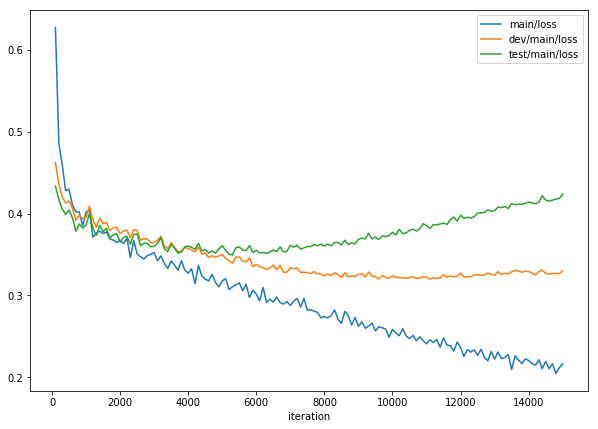

In [31]:
rcParams['figure.figsize'] = 10,7
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss", "test/main/loss"]].values, columns=["main/loss", "dev/main/loss", "test/main/loss"], index=log_df["iteration"]).plot()
log_df.tail()

In [32]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
# pd.crosstab(Y_dev, y_pred)
Category_Evaluation(Y_dev, y_pred)

             precision    recall  f1-score   support

          0       0.94      0.97      0.96      6956
          1       0.33      0.19      0.24       456
          2       0.44      0.41      0.42       327
          3       0.22      0.22      0.22        60
          4       0.47      0.50      0.48        56

avg / total       0.88      0.89      0.89      7855

[[6766   96   64   16   14]
 [ 256   88   91   12    9]
 [ 107   69  135   12    4]
 [  22    6   14   13    5]
 [  11    5    5    7   28]]
Accuracy :  0.8949713558243158
F1 average :  0.4653781476073234
Weighted F1 :  0.3558213039667302
ETS 800m :  0.31485142757457696
BI 800m :  1.0714285714285714
ETS 1600m :  0.2826710781886066
BI 1600m :  1.0344827586206897


In [33]:
with configuration.using_config('train', False):
    y_calc = model(X_test)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_test, y_pred))
# pd.crosstab(Y_test, y_pred)
Category_Evaluation(Y_test, y_pred)

             precision    recall  f1-score   support

          0       0.94      0.96      0.95      7302
          1       0.27      0.22      0.24       376
          2       0.33      0.28      0.30       360
          3       0.07      0.04      0.05        55
          4       0.14      0.09      0.11        44

avg / total       0.87      0.88      0.88      8137

[[7014  146  114   14   14]
 [ 223   82   63    4    4]
 [ 185   66   99    4    6]
 [  34    6   12    2    1]
 [  21    3   10    6    4]]
Accuracy :  0.8849698906230797
F1 average :  0.32965520736830556
Weighted F1 :  0.10658650718073143
ETS 800m :  0.0558252123882273
BI 800m :  0.6590909090909091
ETS 1600m :  0.08512602808801183
BI 1600m :  0.5959595959595959
